In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
os.chdir('/content/drive/My Drive/project_captcha/dataset/')
!ls

captcha_labelled  combined  deskewed  label.csv  letters  processed


In [ ]:
import cv2
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset, sampler, random_split, SubsetRandomSampler, WeightedRandomSampler
from torchsummary import summary


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
np.random.seed(0)
torch.manual_seed(0)

In [ ]:
''' Declaring important parameters '''

data_dir = 'letters'
nThreads = 4
batch_size = 32

## Loading/Splitting Dataset

In [ ]:
''' Loading dataset and splitting it into train and test set '''
def load_split_train_test(datadir, valid_size = .2):

    train_transforms = transforms.Compose([transforms.Resize(100),
                                           transforms.ToTensor(),
                                           ])
    test_transforms = transforms.Compose([transforms.Resize(100),
                                          transforms.ToTensor(),
                                          ])
    train_data = datasets.ImageFolder(datadir, transform=train_transforms)
    test_data = datasets.ImageFolder(datadir, transform=test_transforms)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)

    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = sampler.SubsetRandomSampler(train_idx)
    test_sampler = sampler.SubsetRandomSampler(test_idx)
    trainloader = DataLoader(train_data,
                   sampler=train_sampler, batch_size=64)
    testloader = DataLoader(test_data,
                   sampler=test_sampler, batch_size=64)
    return trainloader, testloader

trainloader, testloader = load_split_train_test(data_dir, .2)
print(testloader.dataset.classes)

['2', '3', '4', '5', '6', '7', '8', '9', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


Another method of splitting

In [ ]:
image_transforms = {
    "train": transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((100, 100)),
        transforms.ToTensor()
    ])
}

In [ ]:
letters_dataset = datasets.ImageFolder(
                              root = data_dir,
                              transform = image_transforms["train"]
                       )

In [ ]:
letters_dataset

Dataset ImageFolder
    Number of datapoints: 10355
    Root location: letters
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               Resize(size=(100, 100), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )

In [ ]:
print(letters_dataset.classes)
print(letters_dataset.class_to_idx)

['2', '3', '4', '5', '6', '7', '8', '9', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
{'2': 0, '3': 1, '4': 2, '5': 3, '6': 4, '7': 5, '8': 6, '9': 7, 'A': 8, 'C': 9, 'D': 10, 'E': 11, 'F': 12, 'G': 13, 'H': 14, 'J': 15, 'K': 16, 'M': 17, 'N': 18, 'P': 19, 'Q': 20, 'R': 21, 'S': 22, 'T': 23, 'U': 24, 'V': 25, 'W': 26, 'X': 27, 'Y': 28, 'Z': 29}


In [ ]:
idx2class = {v: k for k, v in letters_dataset.class_to_idx.items()}
print(idx2class)

{0: '2', 1: '3', 2: '4', 3: '5', 4: '6', 5: '7', 6: '8', 7: '9', 8: 'A', 9: 'C', 10: 'D', 11: 'E', 12: 'F', 13: 'G', 14: 'H', 15: 'J', 16: 'K', 17: 'M', 18: 'N', 19: 'P', 20: 'Q', 21: 'R', 22: 'S', 23: 'T', 24: 'U', 25: 'V', 26: 'W', 27: 'X', 28: 'Y', 29: 'Z'}


In [ ]:
def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k,v in dataset_obj.class_to_idx.items()}
    
    for element in dataset_obj:
        y_lbl = element[1]
        y_lbl = idx2class[y_lbl]
        count_dict[y_lbl] += 1
            
    return count_dict
# print("Distribution of classes: \n", get_class_distribution(letters_dataset))


In [ ]:
plt.figure(figsize=(15,8))
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(letters_dataset)]).melt(),
            x = "variable", y="value", hue="variable").set_title('Letters Class Distribution')

Random split

In [ ]:
train_dataset, val_dataset = random_split(letters_dataset, (8000, 2355))

train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=32)
val_loader = DataLoader(dataset=val_dataset, shuffle=False, batch_size=32)
print("Length of the train_loader:", len(train_loader))
print("Length of the val_loader:", len(val_loader))


Length of the train_loader: 250
Length of the val_loader: 74


<class 'torch.Tensor'>
torch.Size([32, 1, 100, 100])
torch.Size([32])
{0.0, 0.007843138, 0.99215686, 0.003921569, 0.011764706, 1.0, 0.99607843, 0.98039216, 0.9882353, 0.9843137, 0.019607844, 0.015686275, 0.972549, 0.9764706, 0.02745098, 0.023529412}


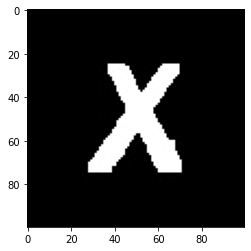

In [ ]:
''' Vizualize Images from dataloader '''

dataiter = iter(train_loader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)
image = np.transpose(images[0].numpy(), (1, 2, 0))
image = image.reshape(100,100)
print(set(image.flatten()))
plt.imshow(image, cmap='gray')

Model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
print(device)

cuda


##Training

In [ ]:
class CustomNet(nn.Module):
    def __init__(self):
        super(CustomNet, self).__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size = 3),
            nn.ReLU(),
            nn.AvgPool2d(2, stride = 2),
            nn.Conv2d(4, 8, kernel_size = 3),
            nn.ReLU(),
            nn.AvgPool2d(2, stride = 2),
            nn.Conv2d(8,16,kernel_size = 3),
            nn.ReLU(),
            nn.AvgPool2d(2, stride = 2),
            nn.Conv2d(16,32,kernel_size = 3),
            nn.ReLU())

        self.fc_model = nn.Sequential(
            nn.Linear(2048, 512), # (N, 2592) -> (N, 512)
            nn.ReLU(),
            nn.Linear(512, 30))  # (N, 512)  -> (N, 30)) #30 classes

    def forward(self, x):
        # print(x.shape)
        x = self.cnn_model(x)
        # print(x.shape) 
        x = x.view(x.size(0), -1)
        # print(x.shape)    
        x = self.fc_model(x)
        # print(x.shape)
        return x

In [ ]:
model = CustomNet().to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
summary(model, (1, 100, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 98, 98]              40
              ReLU-2            [-1, 4, 98, 98]               0
         AvgPool2d-3            [-1, 4, 49, 49]               0
            Conv2d-4            [-1, 8, 47, 47]             296
              ReLU-5            [-1, 8, 47, 47]               0
         AvgPool2d-6            [-1, 8, 23, 23]               0
            Conv2d-7           [-1, 16, 21, 21]           1,168
              ReLU-8           [-1, 16, 21, 21]               0
         AvgPool2d-9           [-1, 16, 10, 10]               0
           Conv2d-10             [-1, 32, 8, 8]           4,640
             ReLU-11             [-1, 32, 8, 8]               0
           Linear-12                  [-1, 512]       1,049,088
             ReLU-13                  [-1, 512]               0
           Linear-14                   

In [ ]:
# Find total parameters and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

1,070,622 total parameters.
1,070,622 training parameters.


In [ ]:
def evaluation(dataloader):
    total, correct = 0, 0
    #keeping the network in evaluation mode 
    model.eval()
    for data in dataloader:
        inputs, labels = data
        #moving the inputs and labels to gpu
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

In [ ]:
iter = []
loss_arr = []
loss_epoch_arr = []
max_epochs = 10 #epoch count

for epoch in range(max_epochs):

    for i, data in enumerate(train_loader, 0):

        inputs, labels = data
        # print(labels)
        inputs, labels = inputs.to(device), labels.to(device)
        # print()
        #forward pass
        outputs = model(inputs)
        # print('a')
        loss = loss_fn(outputs, labels)
        
        #backward and optimize
        opt.zero_grad()
        loss.backward()
        opt.step()

        if (i+1)%50 ==0:
            iter.append(i)
            loss_arr.append(loss.item())
            print('Epoch: %d/%d, Iterations: %d/%d, Loss: %0.4f, Test acc: %0.2f, Train acc: %0.2f' % (epoch+1, max_epochs, i+1, len(train_loader), loss.data, evaluation(val_loader), evaluation(train_loader)))
    loss_epoch_arr.append(loss.item())
        
    # print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (epoch, max_epochs, evaluation(val_loader), evaluation(train_loader)))


Epoch: 1/10, Iterations: 50/250, Loss: 2.3231, Test acc: 30.28, Train acc: 30.94
Epoch: 1/10, Iterations: 100/250, Loss: 0.8460, Test acc: 76.35, Train acc: 77.03
Epoch: 1/10, Iterations: 150/250, Loss: 0.4211, Test acc: 89.64, Train acc: 90.30
Epoch: 1/10, Iterations: 200/250, Loss: 0.3618, Test acc: 91.80, Train acc: 91.92
Epoch: 1/10, Iterations: 250/250, Loss: 0.2621, Test acc: 92.87, Train acc: 92.99
Epoch: 2/10, Iterations: 50/250, Loss: 0.0599, Test acc: 94.95, Train acc: 95.81
Epoch: 2/10, Iterations: 100/250, Loss: 0.0663, Test acc: 94.39, Train acc: 94.85
Epoch: 2/10, Iterations: 150/250, Loss: 0.1715, Test acc: 94.82, Train acc: 95.66
Epoch: 2/10, Iterations: 200/250, Loss: 0.0438, Test acc: 95.75, Train acc: 96.79
Epoch: 2/10, Iterations: 250/250, Loss: 0.0449, Test acc: 95.67, Train acc: 97.25
Epoch: 3/10, Iterations: 50/250, Loss: 0.0325, Test acc: 95.75, Train acc: 97.10
Epoch: 3/10, Iterations: 100/250, Loss: 0.0471, Test acc: 95.92, Train acc: 97.80
Epoch: 3/10, Iterat

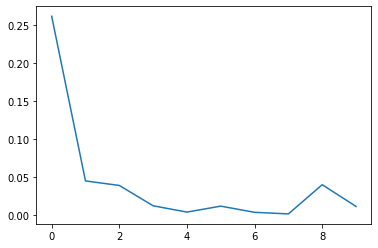

In [ ]:
plt.plot(loss_epoch_arr)
plt.show()

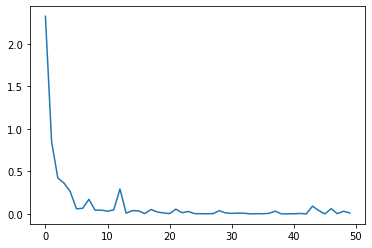

In [ ]:
plt.plot(loss_arr)
plt.show()

In [ ]:
model_path = '../models/pytorch/lenet6.pth'
torch.save(model.state_dict(), model_path)

In [ ]:
full_model_path = '../models/pytorch/lenet6_full.pth'
torch.save(model, full_model_path)

## Inference

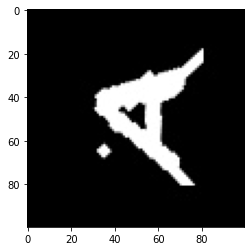

In [ ]:
from PIL import Image
img = Image.open('letters/A/7531.jpg')
# img = cv2.imread('letters/2/24.jpg',-1)
plt.imshow(img,cmap='gray')

In [ ]:
img_t = image_transforms["train"](img)
batch_t = torch.unsqueeze(img_t, 0)


In [ ]:
full_model_path = '../models/pytorch/lenet5_full.pth'
model = torch.load(full_model_path)
model.eval()

CustomNet(
  (cnn_model): Sequential(
    (0): Conv2d(1, 4, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (9): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU()
    (11): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=30, bias=True)
  )
)

In [ ]:
out = model(batch_t.to(device))
print(out.shape)

torch.Size([1, 30])


In [ ]:
prediction = int(torch.max(out.cpu().data, 1)[1].numpy())
print(prediction)

8


In [ ]:
letter = idx2class[prediction]
print(letter)

A
